In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, jaccard_similarity_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from collections import defaultdict
import pandas as pd
import distance
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [52]:
df = pd.read_csv('/Users/bettychou1993/Desktop/ebay/training.csv')
df_test = pd.read_csv('/Users/bettychou1993/Desktop/ebay/test.csv')

In [54]:
def preprocess(df):
    
    """feature engineering"""
    
    df = df.drop(["RefId", "PurchDate", "VehYear", "PRIMEUNIT", "AUCGUART"], axis=1)
    acquisition_price = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                    'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                    'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                    'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
    df['Avg'] = df[acquisition_price].mean(axis=1)
    df = df.drop(acquisition_price, axis=1)
    
    """missing value"""
    numerical_cols = ['VehicleAge', 'WheelTypeID', 'VehOdo', 'BYRNO', 'VNZIP1', 
                      'IsOnlineSale', 'WarrantyCost','Avg']
    nominal_cols = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
                    'Transmission', 'WheelType','Nationality', 'Size', 
                    'TopThreeAmericanName', 'VNST']
    
    for col in numerical_cols:
        median = df[col].median()
        df[col] = df[col].fillna(median)
        
    for col in nominal_cols:
        mode = df[col].mode()[0]
        df[col] = df[col].fillna(mode)
    for col in nominal_cols:
        s = set(df[col])
        df[col] = df[col].map(lambda x: list(s).index(x))
    return df

In [65]:
def visualizeClassLabel(df, cols):
    """visuzlize with repect of the class label, which is the IsBadBuy"""
    for col in cols:
        plt.hist(df[df["IsBadBuy"]==0][col].reset_index(drop=True), alpha=0.6, label="Good")
        plt.hist(df[df["IsBadBuy"]==1][col].reset_index(drop=True), alpha=0.6, label="Bad")
        plt.legend()
        plt.title('Distribution of class labe w.r.t to'+ col)
        plt.show()

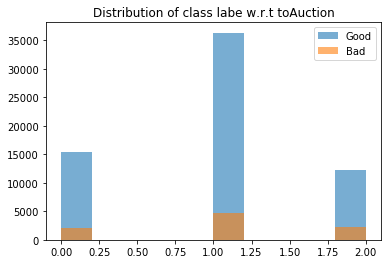

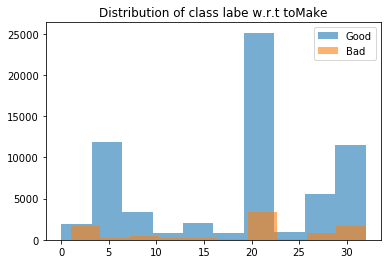

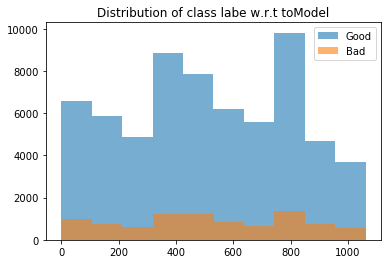

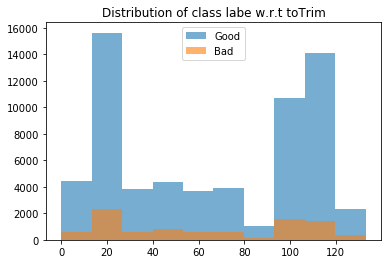

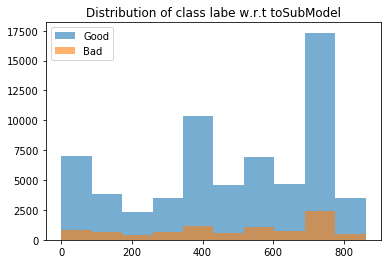

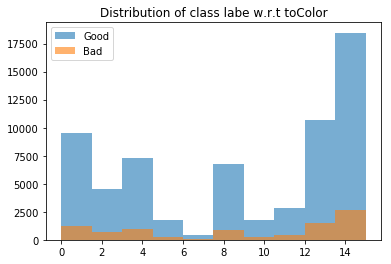

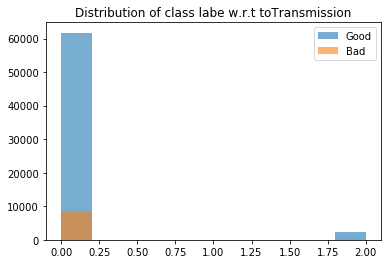

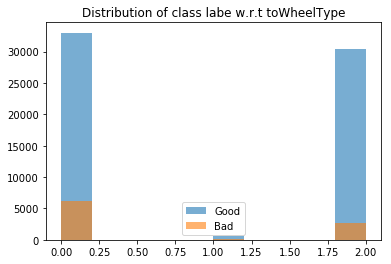

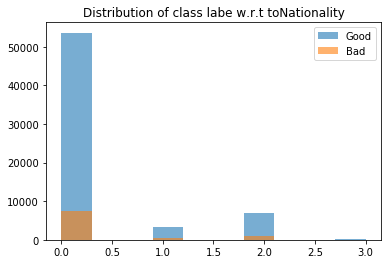

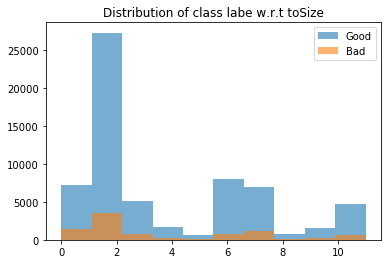

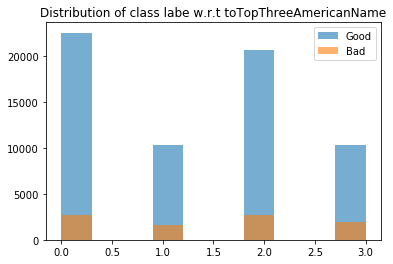

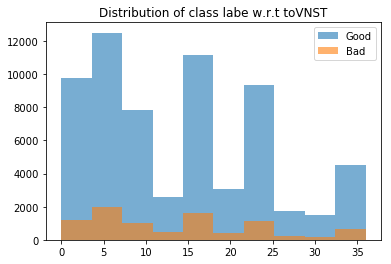

In [67]:
nominal_cols = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
                    'Transmission', 'WheelType','Nationality', 'Size', 
                    'TopThreeAmericanName', 'VNST']
df_ = preprocess(df)
visualizeClassLabel(df_, nominal_cols)

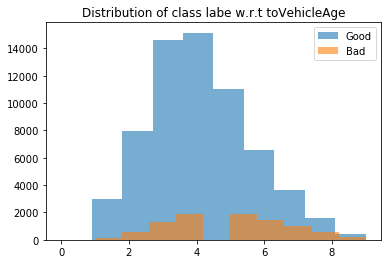

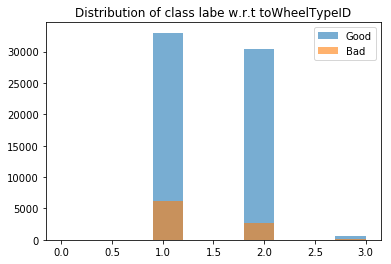

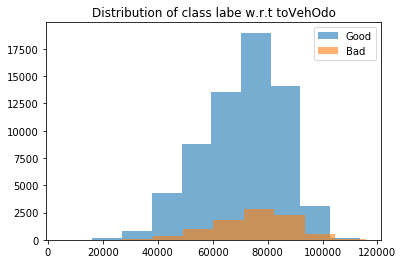

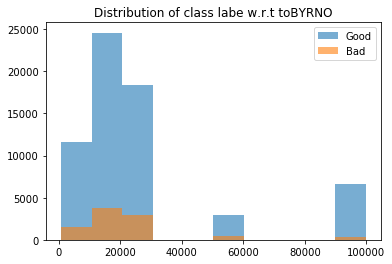

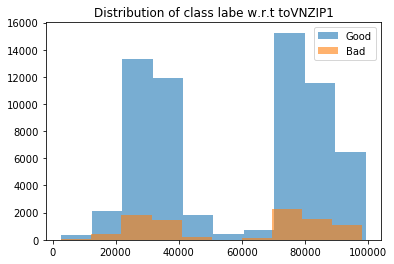

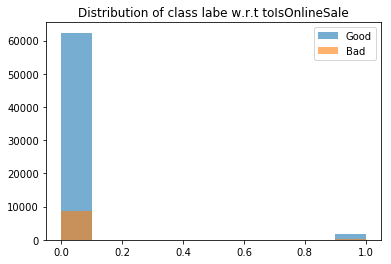

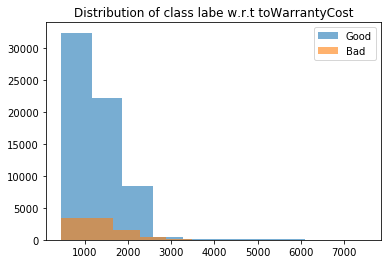

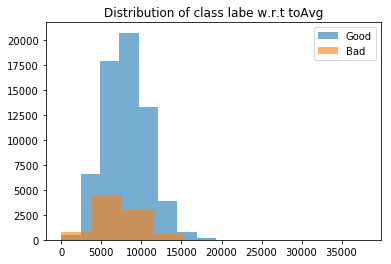

In [68]:
numerical_cols = ['VehicleAge', 'WheelTypeID', 'VehOdo', 'BYRNO', 'VNZIP1', 
                      'IsOnlineSale', 'WarrantyCost','Avg']
df__ = preprocess(df)
visualizeClassLabel(df__, numerical_cols)

In [42]:
## split traning set
def splitTraining(df):
    df_label = df.loc[:,'IsBadBuy']
    df_features = df.iloc[:,1:]
    X_train, X_test, y_train, y_test = train_test_split(
        df_features, df_label, test_size=0.3)
    return X_train, X_test, y_train, y_test 

In [43]:
def KNN(X_train, X_test, y_train, y_test):
    knn = KNeighborsRegressor(n_neighbors=1000)
    # Fit the model on the training data.
    knn.fit(X_train, y_train)
    # Make point predictions on the test set using the fit model.
    predictions = knn.predict(X_test)
    mse = (((predictions - y_test) ** 2).sum()) / len(predictions)
    return mse 

In [44]:
#logistic regression
def LogitRegression(X_train, X_test, y_train, y_test): 
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train) 
    y_pred = LogReg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [45]:
def main(df):
    df = preprocess(df)
    X_train, X_test, y_train, y_test = splitTraining(df)
    mse_knn = KNN(X_train, X_test, y_train, y_test)
    accuracy_logit = LogitRegression(X_train, X_test, y_train, y_test)
    return mse_knn, accuracy_logit

In [46]:
main(df)

(0.10377489536423648, 0.87956154373144557)

In [47]:
def upSampling(df):
    df_majority = df[df.IsBadBuy==0]
    df_minority = df[df.IsBadBuy==1]
    diff = len(df_majority)-len(df_minority)
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=diff,# to match majority class
                                 random_state= int(diff * 0.2))# reproducible results
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

In [48]:
def downSampling(df):
    df_majority = df[df.IsBadBuy==0]
    df_minority = df[df.IsBadBuy==1]
    df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority),# to match majority class
                                 random_state= int(len(df_minority) * 5))# reproducible results
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

In [49]:
df_downsampled = downSampling(df)
df_upsampled = upSampling(df)

In [50]:
main(df_downsampled)

(0.24065523356851012, 0.62105458596360941)

In [179]:
df_RefId = df_test['RefId']
df2 = preprocess(df_test)